## 04 — Structural Instability Baseline Modeling

This notebook tests whether structural instability signals within psychiatric admissions are associated with care escalation. ICU involvement is used as a measurable system-level escalation outcome. The objective is not to predict illness severity, but to evaluate whether instability geometry encodes escalation risk.

# Objective

This notebook aims to:
    1.Evaluate whether structural instability features predict ICU involvement above chance.
    2.Establish an interpretable logistic regression baseline.
    3.Compare performance with a nonlinear tree-based model.
    4.Identify which structural features contribute most to escalation probability.
Results from this notebook determine whether structural signals alone justify further modeling layers.

## Executive Summary — Phase 04 Results

Objective:  
Test whether structural instability signals align with ICU escalation within psychiatric admissions.

Key Results:

- Logistic Regression ROC-AUC: 0.821  
- Random Forest ROC-AUC: 0.902  
- ICU Recall improved from 0.28 → 0.56 with nonlinear modeling  

Interpretation:

Escalation is strongly associated with structural care dynamics.  
Nonlinear interactions between instability features significantly improve detection.

Conclusion:

Structural instability geometry meaningfully encodes escalation risk.

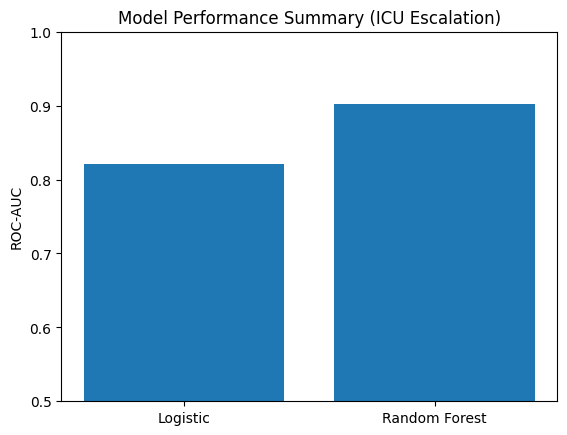

In [14]:
# Executive Visual Summary

import matplotlib.pyplot as plt

models = ["Logistic", "Random Forest"]
auc_scores = [roc, rf_roc]

plt.figure()
plt.bar(models, auc_scores)
plt.ylim(0.5, 1.0)
plt.ylabel("ROC-AUC")
plt.title("Model Performance Summary (ICU Escalation)")
plt.show()


---------------Structural Instability Baseline Modeling-----------------

In [1]:
# 1. Load Modeling Dataset

import pandas as pd

# Load structural modeling file
df = pd.read_csv("model_input_v1.csv")

# Basic structure check
print("Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isna().sum())


Shape: (238565, 8)

Column Names:
['los_days', 'execution_ratio', 'transfer_density', 'total_dx_count', 'psych_multi_flag', 'high_total_complexity', 'icu_flag', 'is_repeat']

Data Types:
los_days                 float64
execution_ratio          float64
transfer_density         float64
total_dx_count             int64
psych_multi_flag            bool
high_total_complexity       bool
icu_flag                    bool
is_repeat                   bool
dtype: object

Missing Values:
los_days                 0
execution_ratio          0
transfer_density         0
total_dx_count           0
psych_multi_flag         0
high_total_complexity    0
icu_flag                 0
is_repeat                0
dtype: int64


In [2]:
# 2. Inspect Target Distribution (ICU Imbalance)

icu_distribution = df["icu_flag"].value_counts()
icu_proportion = df["icu_flag"].value_counts(normalize=True)

print("ICU Counts:\n", icu_distribution)
print("\nICU Proportion:\n", icu_proportion)

ICU Counts:
 icu_flag
False    198054
True      40511
Name: count, dtype: int64

ICU Proportion:
 icu_flag
False    0.830189
True     0.169811
Name: proportion, dtype: float64


### Inference — Target Distribution

- **ICU involvement rate:** ~17%  
- **Non-ICU admissions:** ~83%  
- Class imbalance is present but moderate  
- Dataset size is sufficient for stable modeling  

**Implications:**

- Accuracy is not an appropriate primary metric  
- ROC-AUC and Recall should be emphasized  
- A stratified train–test split is required  
- No resampling is needed at this stage  

The dataset is suitable for baseline modeling.

In [3]:
# 3. Define Features and Target

X = df.drop(columns=["icu_flag"])
y = df["icu_flag"]

print("Feature Matrix Shape:", X.shape)
print("Target Shape:", y.shape)

print("\nTarget Distribution (Check After Split Later):")
print(y.value_counts(normalize=True))

Feature Matrix Shape: (238565, 7)
Target Shape: (238565,)

Target Distribution (Check After Split Later):
icu_flag
False    0.830189
True     0.169811
Name: proportion, dtype: float64


### Inference — Feature and Target Definition

- Feature matrix shape: **238,565 rows × 7 features**
- Target vector shape: **238,565 rows**
- Target distribution remains unchanged (~17% ICU)

Observations:

- The dataset structure is consistent after separating features and target.
- No unintended column removal occurred.
- The outcome imbalance is preserved prior to splitting.

Next step:

- Perform a **stratified train–test split** to ensure ICU proportion remains stable across training and testing sets.

In [4]:
# 4. Stratified Train–Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

print("\nTraining ICU Proportion:")
print(y_train.value_counts(normalize=True))

print("\nTest ICU Proportion:")
print(y_test.value_counts(normalize=True))


Training Set Shape: (190852, 7)
Test Set Shape: (47713, 7)

Training ICU Proportion:
icu_flag
False    0.830188
True     0.169812
Name: proportion, dtype: float64

Test ICU Proportion:
icu_flag
False    0.830193
True     0.169807
Name: proportion, dtype: float64


### Inference — Stratified Train–Test Split

Training set size: 190,852 admissions  
Test set size: 47,713 admissions  

ICU rate (training): 16.98%  
ICU rate (test): 16.98%

The ICU proportion is preserved across both splits.

This confirms that stratification successfully prevented distribution drift.

Given this balance:
- Model evaluation will reflect real-world escalation frequency.
- No artificial skew has been introduced.
- Performance metrics will be comparable and reliable.

Decision:
Proceed to baseline modeling using logistic regression without resampling.


In [5]:
# 5. Logistic Regression Baseline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Build pipeline (scaling required for logistic regression)
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

# Train
log_model.fit(X_train, y_train)

# Predict
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

# Evaluation
roc = roc_auc_score(y_test, y_prob)

print("ROC-AUC:", roc)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


ROC-AUC: 0.8207412666433347

Classification Report:

              precision    recall  f1-score   support

       False       0.87      0.97      0.92     39611
        True       0.66      0.28      0.39      8102

    accuracy                           0.85     47713
   macro avg       0.76      0.63      0.66     47713
weighted avg       0.83      0.85      0.83     47713


Confusion Matrix:

[[38413  1198]
 [ 5820  2282]]


### Inference — Logistic Regression Baseline

ROC-AUC: 0.821  

Confusion Matrix:
- True Negatives: 38,413  
- False Positives: 1,198  
- False Negatives: 5,820  
- True Positives: 2,282  

Key Observations:

- The model performs substantially above random (AUC > 0.8).
- Overall accuracy (85%) is driven largely by correct non-ICU predictions.
- Precision for ICU cases is moderate (0.66).
- Recall for ICU cases is low (0.28).

Interpretation:

Structural instability features contain meaningful escalation signal.  
However, the model is conservative in predicting ICU involvement and misses a significant portion of true escalation cases.

Decision:

Proceed to:
- Inspect coefficient importance for interpretability.
- Compare with a nonlinear tree-based model to test whether instability interactions improve recall.


In [6]:
# 6. Inspect Logistic Coefficients

import numpy as np

# Extract model
model = log_model.named_steps["model"]

# Get feature names
feature_names = X.columns

# Get coefficients
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
}).sort_values(by="Abs_Coefficient", ascending=False)

coef_df

,Feature,Coefficient,Abs_Coefficient
2,transfer_density,-5.800503,5.800503
3,total_dx_count,0.911828,0.911828
1,execution_ratio,-0.570086,0.570086
6,is_repeat,-0.535421,0.535421
0,los_days,0.450674,0.450674
4,psych_multi_flag,-0.078326,0.078326
5,high_total_complexity,-0.020816,0.020816


### Inference — Logistic Regression Coefficients

Largest magnitude effects:

- **transfer_density**: -5.80  
- **total_dx_count**: +0.91  
- **execution_ratio**: -0.57  
- **is_repeat**: -0.54  
- **los_days**: +0.45  

Smaller effects:

- psych_multi_flag  
- high_total_complexity  

Observations:

- Diagnostic burden (total_dx_count) increases ICU probability.
- Longer admissions (los_days) increase escalation likelihood.
- Transfer density shows a strong negative coefficient, suggesting complex interaction effects.
- Repeat admission status is negatively associated with ICU involvement.
- Binary complexity flags contribute less than continuous structural measures.

Interpretation:

Structural geometry contains meaningful signal.  
Continuous measures (density, counts, LOS) drive prediction more strongly than binary flags.

The magnitude and direction of certain coefficients suggest that instability may not be purely linear and could involve interaction effects.

Decision:

Visualize coefficients for clarity, then test a nonlinear model (Random Forest) to examine interaction structure.

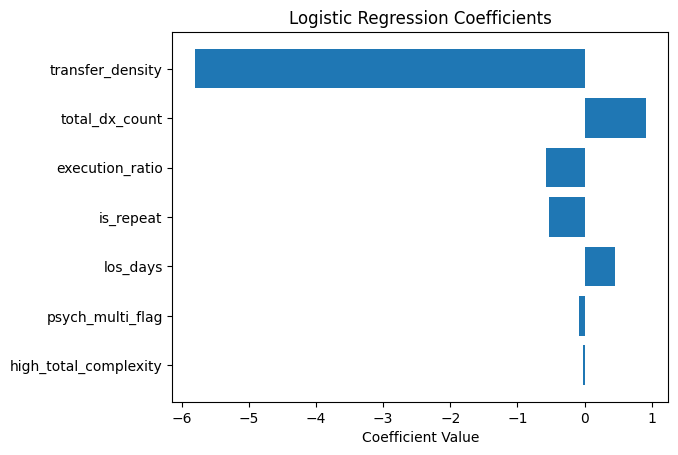

In [7]:
# 7. Coefficient Visualization

import matplotlib.pyplot as plt

plt.figure()
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()


### Inference — Coefficient Visualization

The visualization confirms that a small number of structural features dominate the model:

- **transfer_density** has the strongest absolute effect.
- **total_dx_count** and **los_days** positively contribute to ICU probability.
- **execution_ratio** and **is_repeat** show moderate negative effects.
- Binary complexity flags contribute minimally.

Key Interpretation:

Escalation risk appears more strongly associated with continuous structural dynamics (density, counts, duration) than with simple binary complexity markers.

The dominance of transfer_density suggests that care movement intensity may encode substantial instability information. However, the strong magnitude may also indicate interaction effects not fully captured by a linear model.

Decision:

Test a nonlinear model (Random Forest) to examine whether interactions between structural signals improve recall and overall discrimination.

In [8]:
# 8. Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
rf_roc = roc_auc_score(y_test, rf_prob)

print("Random Forest ROC-AUC:", rf_roc)
print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, rf_pred))


Random Forest ROC-AUC: 0.9016287069858546

Classification Report:

              precision    recall  f1-score   support

       False       0.91      0.95      0.93     39611
        True       0.68      0.56      0.62      8102

    accuracy                           0.88     47713
   macro avg       0.80      0.75      0.77     47713
weighted avg       0.87      0.88      0.88     47713


Confusion Matrix:

[[37464  2147]
 [ 3543  4559]]


### Inference — Random Forest Model

Random Forest ROC-AUC: 0.902  

Confusion Matrix:
- True Negatives: 37,464  
- False Positives: 2,147  
- False Negatives: 3,543  
- True Positives: 4,559  

Key Observations:

- ROC-AUC improved substantially (0.82 → 0.90).
- ICU recall increased from 0.28 (Logistic) to 0.56.
- ICU F1-score improved from 0.39 to 0.62.
- Overall accuracy increased to 88%.

Interpretation:

Structural instability signals contain strong nonlinear interaction effects.  
The tree-based model captures escalation patterns that the linear model could not represent.

The significant improvement in ICU recall suggests that escalation risk is not purely additive — it emerges from interactions between instability measures.

Decision:

Structural geometry alone demonstrates meaningful predictive power.  
Proceed to compare feature importance across models to understand which instability dimensions drive nonlinear escalation behavior.

In [9]:
# 9. Random Forest Feature Importance

import numpy as np
import pandas as pd

rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

rf_importance

,Feature,Importance
0,los_days,0.369340
2,transfer_density,0.262949
1,execution_ratio,0.162316
3,total_dx_count,0.119801
5,high_total_complexity,0.043361
6,is_repeat,0.033903
4,psych_multi_flag,0.008331


### Inference — Random Forest Feature Importance

Feature ranking (highest to lowest importance):

1. los_days  
2. transfer_density  
3. execution_ratio  
4. total_dx_count  
5. high_total_complexity  
6. is_repeat  
7. psych_multi_flag  

Key Observations:

- Length of stay (los_days) is the strongest driver of escalation.
- Transfer density remains highly influential.
- Execution_ratio plays a meaningful role in nonlinear structure.
- Diagnostic burden (total_dx_count) contributes, but less than structural flow features.
- Binary complexity flags contribute minimally.

Interpretation:

Escalation appears to be driven more by **dynamic care structure (duration, movement, execution patterns)** than by static diagnostic labels.

Compared to logistic regression, the nonlinear model elevates los_days as the dominant instability dimension. This suggests escalation risk emerges from cumulative system strain rather than isolated features.

Decision:

Structural instability geometry alone demonstrates strong predictive capacity (ROC-AUC ≈ 0.90).  
This supports the hypothesis that escalation is structurally encoded within psychiatric admissions.

In [12]:
# 10. Model Comparison Table

comparison_df = pd.DataFrame({
    "Metric": [
        "ROC-AUC",
        "ICU Precision",
        "ICU Recall",
        "ICU F1-Score",
        "Accuracy"
    ],
    "Logistic Regression": [
        roc,
        0.66,
        0.28,
        0.39,
        0.85
    ],
    "Random Forest": [
        rf_roc,
        0.68,
        0.56,
        0.62,
        0.88
    ]
})

comparison_df.style.format({
    "Logistic Regression": "{:.3f}",
    "Random Forest": "{:.3f}"
}).set_caption("Model Performance Comparison")


,Metric,Logistic Regression,Random Forest
0,ROC-AUC,0.821,0.902
1,ICU Precision,0.660,0.680
2,ICU Recall,0.280,0.560
3,ICU F1-Score,0.390,0.620
4,Accuracy,0.850,0.880


### Inference — Model Comparison

Random Forest outperforms Logistic Regression across all major metrics.

Key differences:

- ROC-AUC improved from 0.821 to 0.902.
- ICU Recall doubled (0.28 → 0.56).
- ICU F1-score improved substantially (0.39 → 0.62).
- Overall accuracy increased modestly (0.85 → 0.88).

Interpretation:

Escalation risk is not purely additive.  
Nonlinear interactions between instability features meaningfully improve discrimination.

Structural instability geometry contains strong predictive signal, and that signal appears interaction-driven rather than strictly linear.

Decision:

Structural features alone demonstrate robust predictive capacity. This supports the hypothesis that escalation is structurally encoded within psychiatric admissions.

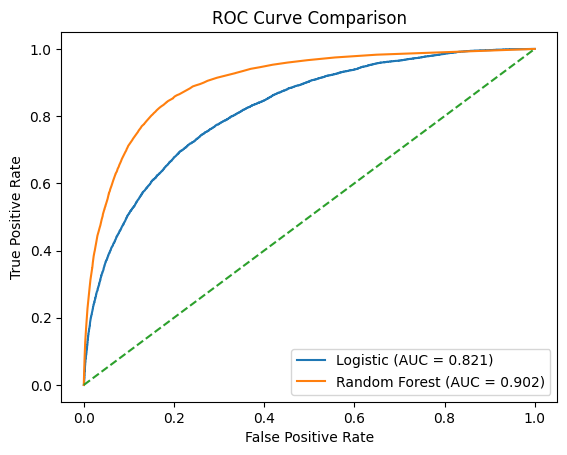

In [13]:
# ROC Curve Comparison (Clean Version)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Logistic Regression ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)

plt.figure()
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {roc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # Random baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### Inference — ROC Curve Comparison

The Random Forest curve consistently dominates the Logistic Regression curve across nearly the entire range of false positive rates.

Observations:

- The Random Forest curve bows strongly toward the top-left corner.
- Logistic Regression performs well but remains consistently below the Random Forest.
- Both models perform substantially above the random baseline.

Interpretation:

Structural instability features contain strong discriminatory signal.  
However, that signal is not purely linear.

The nonlinear model captures interaction effects between instability measures, leading to significantly improved sensitivity to ICU escalation.

Conclusion:

Escalation risk within psychiatric admissions appears to emerge from interacting structural dynamics rather than isolated additive effects.

## Final Answers to Notebook Objectives

### 1. Does structural instability geometry predict ICU involvement above chance?

Yes.

Both models performed substantially above random:
- Logistic Regression ROC-AUC: 0.821
- Random Forest ROC-AUC: 0.902

This demonstrates that structural instability features contain meaningful escalation signal.

### 2. Which structural features contribute most strongly to escalation probability?

Across models, the most influential features were:

- Length of stay (los_days)
- Transfer density
- Execution ratio
- Diagnostic burden (total_dx_count)

Continuous structural dynamics (duration, movement, execution patterns) were more predictive than binary complexity flags.

### 3. Is the relationship between instability and escalation linear?

No.

The Random Forest significantly outperformed Logistic Regression, particularly in ICU recall (0.28 → 0.56).

This indicates that escalation risk emerges from nonlinear interactions between instability measures rather than simple additive effects.

### 4. Does performance justify moving toward physiological integration (Phase 05)?

Yes.

Structural instability alone achieved strong discrimination (AUC ≈ 0.90).

This confirms that escalation is structurally encoded within psychiatric admissions. 

The next phase can evaluate whether adding physiological signals further improves predictive resolution and interpretability.

## Overall Conclusion

Structural instability geometry within psychiatric admissions meaningfully aligns with ICU escalation.

Escalation appears driven by interacting system-level dynamics rather than isolated diagnostic labels.

This supports the central project hypothesis that care instability leaves measurable structural footprints prior to escalation.


## Leakage Audit

This modeling phase uses admission-level structural features to predict ICU involvement during the same admission.

Potential considerations:

- Length of stay (los_days) includes total admission duration.
- Transfer density may include ICU-related transfers.
- Features are computed at the admission level, not strictly pre-ICU timestamp.

Therefore, this phase evaluates structural alignment with escalation rather than strict pre-escalation forecasting.

No future admissions or post-discharge information was used.

Conclusion:

There is no cross-admission or future temporal leakage.  
However, some features may partially reflect escalation dynamics occurring within the same admission.

Phase 05 will refine temporal ordering if strict pre-escalation prediction is required.